In [2]:
import numpy
import sys
from pycirclize import Circos
import pysam
import matplotlib.pyplot as plot

In [3]:
multi_map_bamfile = "./numts_test.bam"

In [5]:
# Open the BAM file
bam_file = pysam.AlignmentFile(multi_map_bamfile, "rb")

Mappingfile = []
# Iterate over each read in the file
for read in bam_file.fetch():
    chromosome = read.reference_name  # Chromosome (reference name) where the read is aligned
    start_position = read.reference_start
    
    if read.has_tag("SA"):
        # Get the SA tag value
        sa_tag = read.get_tag("SA")
        itemlist = sa_tag.split(';')
        for item in itemlist:
            if len(item)<1:
                continue
            itlist = item.split(",")
            chromo = itlist[0]
            p = int(itlist[1])
            strand = itlist[2]
            cigar = itlist[3]
            # length = calculate_query_length_from_cigar(cigar)
            mapping_qual = itlist[5]
            if mapping_qual == 0:
                continue
            if chromo == "chrY" or chromo == "chrM":
                continue
            if strand == "+":
                Mappingfile.append([(chromosome, start_position, start_position), (chromo, p, p)])
            else:
                Mappingfile.append([(chromosome, start_position, start_position), (chromo, p, p)])
            
#         print(f"Read {read.query_name} has SA tag: {sa_tag}")
#         break

bam_file.close()

In [8]:
# chromosome information

text = "##contig=<ID=chr1,length=248387328>, ##contig=<ID=chr2,length=242696752>,##contig=<ID=chr3,length=201105948>,##contig=<ID=chr4,length=193574945>,##contig=<ID=chr5,length=182045439>,##contig=<ID=chr6,length=172126628>,##contig=<ID=chr7,length=160567428>,##contig=<ID=chr8,length=146259331>,##contig=<ID=chr9,length=150617247>,##contig=<ID=chr10,length=134758134>,##contig=<ID=chr11,length=135127769>,##contig=<ID=chr12,length=133324548>,##contig=<ID=chr13,length=113566686>,##contig=<ID=chr14,length=101161492>,##contig=<ID=chr15,length=99753195>,##contig=<ID=chr16,length=96330374>,##contig=<ID=chr17,length=84276897>,##contig=<ID=chr18,length=80542538>,##contig=<ID=chr19,length=61707364>,##contig=<ID=chr20,length=66210255>,##contig=<ID=chr21,length=45090682>,##contig=<ID=chr22,length=51324926>,##contig=<ID=chrX,length=154259566>,##contig=<ID=chrM,length=16569>"

itemlist = text.split("##")
chrlist = {}
for item in itemlist:
    l = item.split(",")
    for i in l:
        if len(i) == 0:
            continue
        if "ID" in i:
            chromo = i.split("ID=")[1]
        if "length" in i:
            length = int(i.split("length=")[1][:-1])
            chrlist[chromo] = length
chrlist

{'chr1': 248387328,
 'chr2': 242696752,
 'chr3': 201105948,
 'chr4': 193574945,
 'chr5': 182045439,
 'chr6': 172126628,
 'chr7': 160567428,
 'chr8': 146259331,
 'chr9': 150617247,
 'chr10': 134758134,
 'chr11': 135127769,
 'chr12': 133324548,
 'chr13': 113566686,
 'chr14': 101161492,
 'chr15': 99753195,
 'chr16': 96330374,
 'chr17': 84276897,
 'chr18': 80542538,
 'chr19': 61707364,
 'chr20': 66210255,
 'chr21': 45090682,
 'chr22': 51324926,
 'chrX': 154259566,
 'chrM': 16569}

In [7]:
import pandas as pd
Mappingfile = pd.DataFrame(Mappingfile)
Mappingfile = Mappingfile.sort_values(by=1)
for index, row in Mappingfile.iterrows():
    print(row.values)
    break

[('chrM', 6190, 6190) ('chr1', 33542582, 33542582)]


In [19]:
total_length = sum(chrlist.values())
print(total_length)
sectors = {}
for chromo, length in chrlist.items():
    
    if chromo != "chrM":
        sectors[chromo] = chrlist["chrM"]/total_length*chrlist[chromo]
    else:
        sectors[chromo] = chrlist['chrM']

sectors
New_mapping = []
for index, row in Mappingfile.iterrows():
    mapping = row.values
    m = []
    for chromo, start, end in mapping:
        if chromo == "chrM":
            m.append((chromo,start, end))
        else:
            if chromo in chrlist:   
                factor = chrlist["chrM"]/total_length * chrlist[chromo]
                # print(chromo, factor)
                m.append((chromo, start/chrlist[chromo]*factor, end/chrlist[chromo]*factor))
            else:
                continue
    if len(m) > 1:
        New_mapping.append(m)

3054832041


In [20]:
distribution = {}
for index, items in Mappingfile.iloc[:,1].items():
    chromo, start, end = items
    distribution[chromo] = distribution.get(chromo, []) + [start]

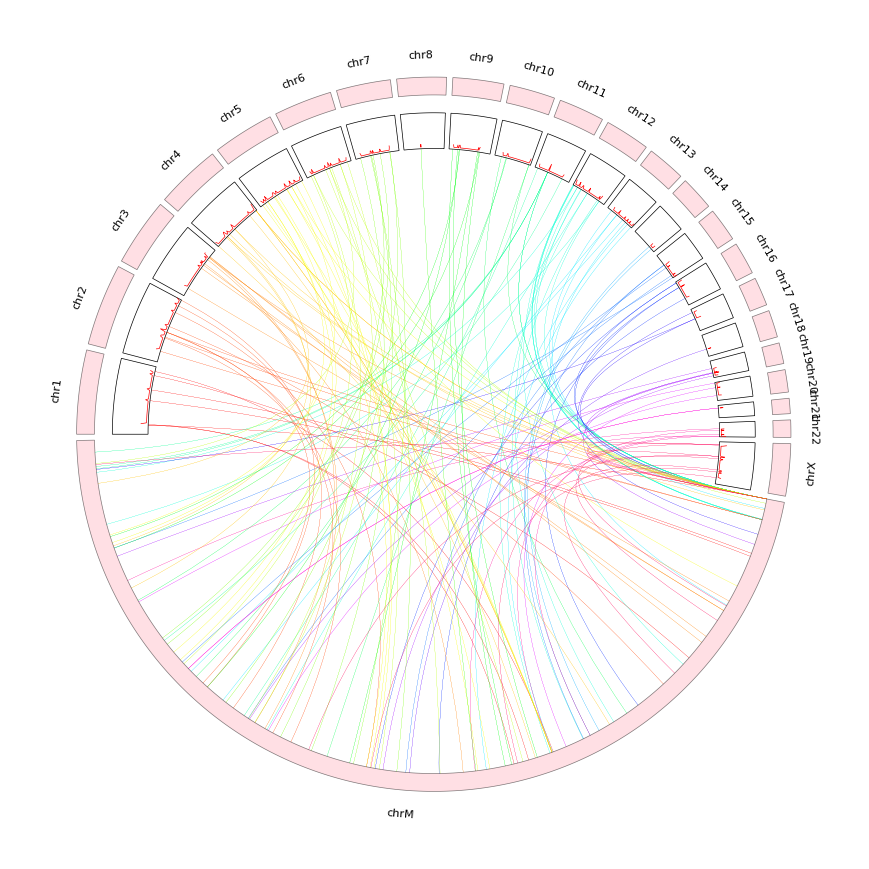

In [23]:
from pycirclize.utils import ColorCycler, load_eukaryote_example_dataset
# Create chromosome color dict
circos = Circos(sectors, space=1, start=-90, end=270) # Set start-end degree ranges

ColorCycler.set_cmap("hsv")
chr_names = [s.name for s in circos.sectors]
colors = ColorCycler.get_color_list(len(chr_names))
chr_name2color = {name: color for name, color in zip(chr_names, colors)}

circos = Circos(sectors, space=1, start=-90, end=270) # Set start-end degree ranges
ymax = 3672


for sector in circos.sectors:
    # Plot sector axis & name text
    #sector.axis(fc="none", ls="dashdot", lw=2, ec="black", alpha=0.5)
    track1 = sector.add_track((95, 100))
    track1.axis(fc="pink", alpha=0.5)
    #track1.text(f"{sector.name}")
    sector.text(f"{sector.name}", size=8)
    
    chromosome = sector.name
    numts = distribution.get(chromosome, [])
    
    if chromo != "chrM":
        f = chrlist["chrM"]/total_length*chrlist[chromo]
    else:
        f = chrlist['chrM']
    
    if len(numts) > 0:
        y,x = numpy.histogram(numts, bins = 50)
        # Scatter track
        track2 = sector.add_track((80, 90), r_pad_ratio=0.1)
        X = sector.start + x/chrlist[chromosome] * (sector.end - sector.start)
        track2.axis()
        track2.line(X[1:], numpy.log10(y+1),color="red", vmin=0, vmax = numpy.log10(ymax))
    
# Plot links
for mapping in New_mapping:
    chro = mapping[1][0]
    color = chr_name2color[chro]
    circos.link(mapping[0], mapping[1],alpha = 1, color = color)
    
fig = circos.plotfig()

In [22]:
# New_mapping